In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

import experiments as meas

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experi

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241007')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [5]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Single shots

In [6]:
best_gain = [0.20, 0.30, 0.78, 0.25]
best_length = [15, 10, 5, 20]

## Import files

In [ ]:
filename = '_multi_readout_qubit'

# # Q0 
# qubit = 0
# # idx = np.arange(2, 62)
# # file_nb =  ['0000'+str(i) for i in idx]
# # # trim zeros to make all element 5 digits
# # file_nb = [i[-5:] for i in file_nb]
# file_nb = ['00063']


# # #Q1
# qubit = 1
# # idx = np.arange(27, 87)
# # file_nb =  ['000'+str(i) for i in idx]
# # file_nb = [i[-5:] for i in file_nb]
# file_nb = ['00088']


# # Q3
# qubit = 3
# # idx = np.arange(3, 63)
# # file_nb =  ['0000'+str(i) for i in idx]
# # # trim zeros to make all element 5 digits
# # file_nb = [i[-5:] for i in file_nb]

# file_nb = ['00104']

# idx = np.arange(63, 83)
# file_nb =  ['000'+str(i) for i in idx]
# idx = np.arange(83, 103)
# file_nb =  ['000'+str(i) for i in idx]
# file_nb = [i[-5:] for i in file_nb]


# # Q2 
qubit = 2
# idx = np.arange(0, 40)
# file_nb =  ['0000'+str(i) for i in idx]
# # trim zeros to make all element 5 digits
# file_nb = [i[-5:] for i in file_nb]
file_nb = ['00040']



data = []


for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)

pop_g = []
perr_g = []
gain_list = []
ro_length = []
pop_qnd_g = []

### Check QNDness

In [ ]:
for idx, d in enumerate(data):
    _data, _attrs = data[idx]
    
    
    shot = meas.MultiReadoutExperiment(config_file=config_path)
    
    config =  AttrDict(_attrs['config'])
    shot.cfg = config
    
    gain_list.append(config.device.readout.gain[qubit])
    ro_length.append(config.device.readout.readout_length[qubit])
    optimal = False
    print(np.round(gain_list[-1], 2))
    print(best_gain[qubit])
    if np.round(gain_list[-1], 2) == np.round(best_gain[qubit],2) and ro_length[-1] == best_length[qubit]:
        print('Optimal')
        optimal = True

        _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 1], verbose=False, fit=True, plot=True, check_qnd=True, opti_post_select=optimal)
    # shot.display(data=_d, fit=False, verbose=False)
    
    
    popts_g = _d['popts'][0]
    pcovs_g = _d['pcovs'][0]
    pop_qnd_g.append(_d['n_diff_qnd'])
    
    perr = np.sqrt(np.diag(pcovs_g))
    print(perr)
    
    pg = popts_g[0]/(popts_g[3] + popts_g[0])
    # using the formula for the error of a ratio
    
    pop_g_err = 1/(popts_g[3] + popts_g[0]) * np.sqrt((popts_g[3]/popts_g[0])**2*perr[0]**2 + perr[3]**2)
    # pop_g_err = pg*np.sqrt((perr[0]/popts_g[0])**2 + (perr[3]/popts_g[3])**2)
    perr_g.append(pop_g_err)
    
    
    pop_g.append(popts_g[0]/(popts_g[3] + popts_g[0]))

    

In [255]:
# convert the pop_g to numpy array

pop_g = np.array(pop_g)
perr_g = np.array(perr_g)

gain = np.array(gain_list)
ro_length = np.array(ro_length)

gain = np.unique(gain)
ro_length = np.unique(ro_length)

# reshape both using the gain_list and 

pop_g = pop_g.reshape(ro_length.size, gain.size)
perr_g = perr_g.reshape(ro_length.size, gain.size)
pop_qnd_g = np.array(pop_qnd_g).reshape(ro_length.size, gain.size)

In [ ]:

fig, ax = plt.subplots(1, 2,  figsize=(8,4))

[ax[0].errorbar(gain, pop_g[i, :], yerr=perr_g[i, :], fmt='o', label='qubit'+str(qubit)+' ro_length='+str(ro_length[i])) for i in range(ro_length.size)]

[ax[1].plot(gain, pop_qnd_g[i, :]*100,'-o', label='qubit'+str(qubit)+' ro_length='+str(ro_length[i])) for i in range(ro_length.size)]


ax[0].set_xlabel('Readout Gain')
ax[1].set_xlabel('Readout Gain')
ax[0].set_ylabel('Pop in |g>, prep |g>')
ax[1].set_ylabel('QND Pop in |g>, prep |g>')
ax[0].legend()
fig.tight_layout()





### Play with the waiting time

s:\Connie\experiments\qramLL_4QR2\data\data_240617\00064_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00065_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00066_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00067_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00068_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00069_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00070_multi_readout_qubit0.h5
Extracted data and attrs ['config']
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 1, 'use_gf_readout': False, 'avg_trigs': 

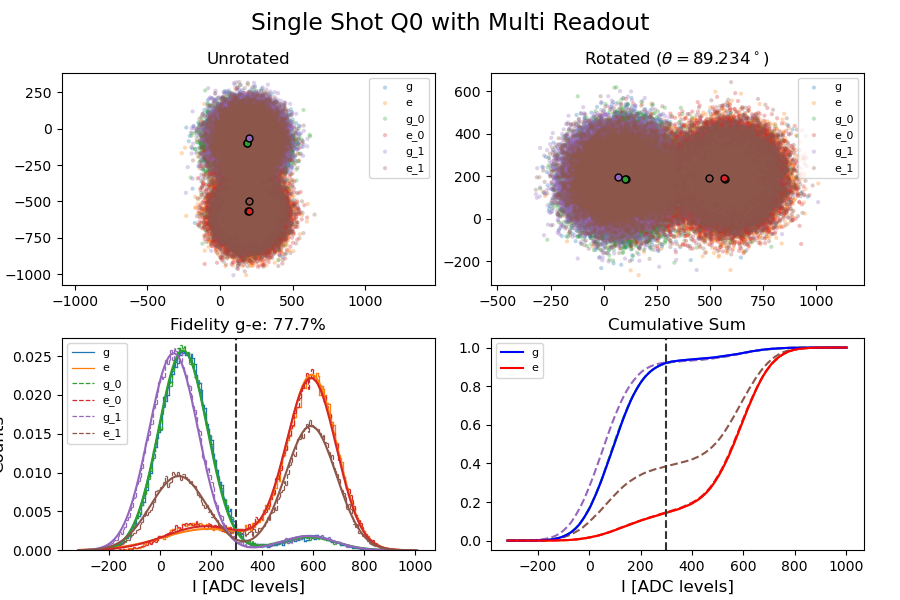

angle 89.23428561057233
11
[-215.93474423 -170.80018398 -125.66562373  -80.53106348  -35.39650322
    9.73805703   54.87261728  100.00717753  145.14173779  190.27629804
  235.41085829  280.54541855  333.82752968  392.54134139  451.25515311
  509.96896483  568.68277655  627.39658827  686.11039998  744.8242117 ]
optimal threshold 280.5454185453987
0.05182425892825879
n_e 0.02567328918322296
n_g 0.974326710816777
n_e_prev 0.07725081511411598
n_g_prev 0.922749184885884
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 2, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


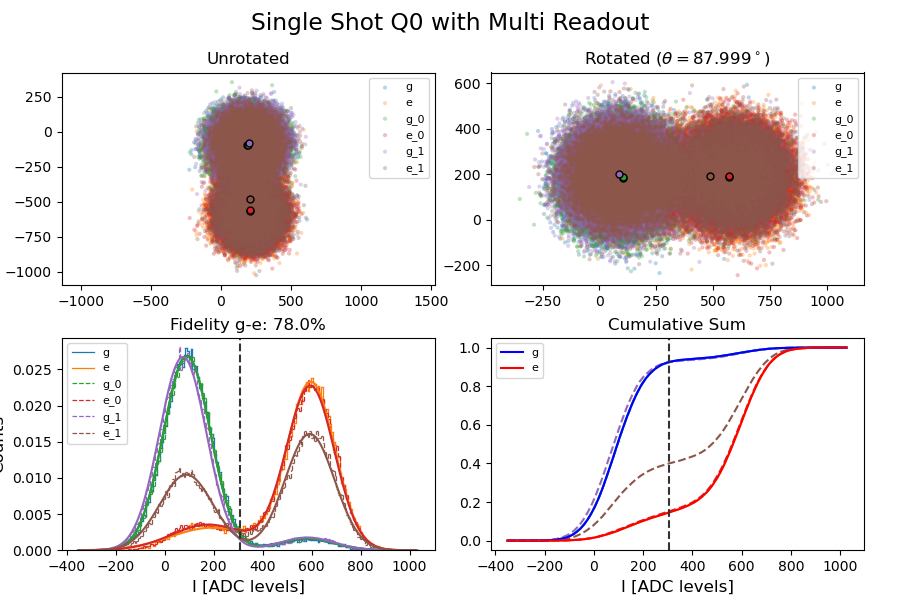

angle 87.99859753989591
11
[-234.8275565  -187.32909354 -139.83063058  -92.33216763  -44.83370467
    2.66475829   50.16322125   97.66168421  145.16014717  192.65861012
  240.15707308  287.65553604  340.96193356  398.14028745  455.31864135
  512.49699524  569.67534913  626.85370302  684.03205691  741.21041081]
optimal threshold 287.65553604170594
0.04700228300894267
n_e 0.028975977555672452
n_g 0.9710240224443275
n_e_prev 0.07594
n_g_prev 0.92406
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 3, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


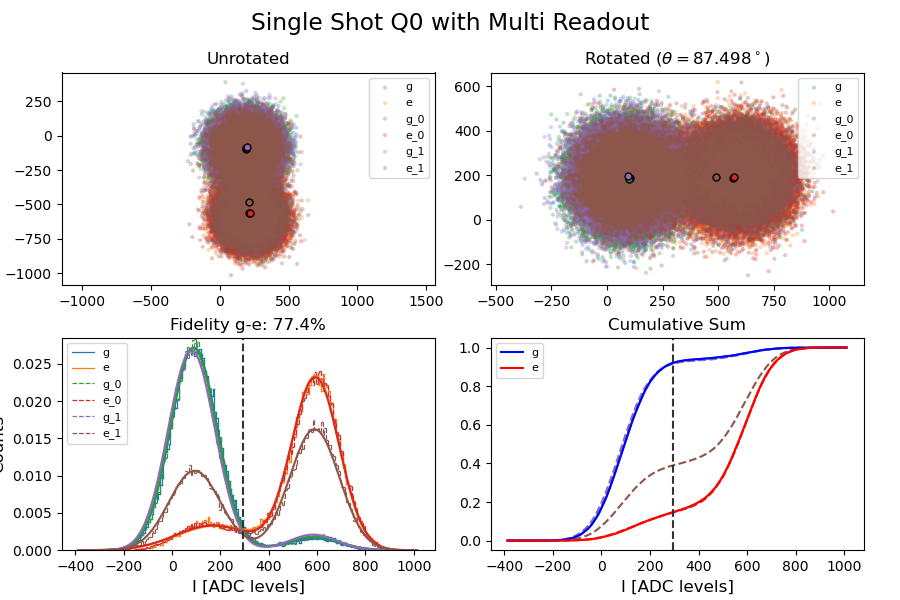

angle 87.49802338392617
11
[-209.72475785 -165.54619709 -121.36763633  -77.18907557  -33.01051481
   11.16804595   55.34660671   99.52516747  143.70372823  187.88228899
  232.06084975  276.2394105   329.39831271  388.54410921  447.68990571
  506.83570221  565.98149871  625.12729521  684.27309171  743.41888821]
optimal threshold 276.2394105049103
0.04808741660376914
n_e 0.03662955107811948
n_g 0.9633704489218805
n_e_prev 0.08462338493539742
n_g_prev 0.9153766150646026
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 5, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


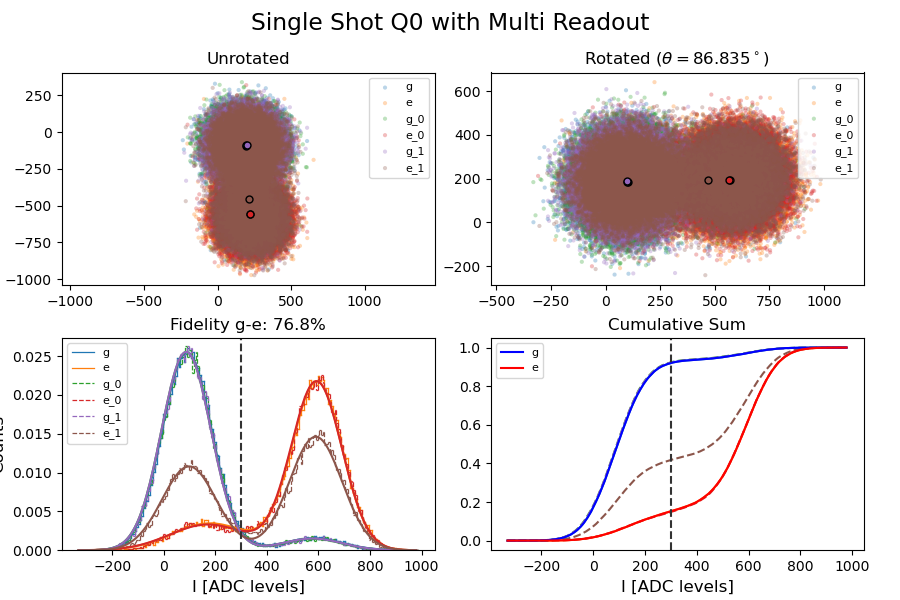

angle 86.83501539533377
11
[-224.5246013  -178.43717606 -132.34975081  -86.26232557  -40.17490032
    5.91252493   51.99995017   98.08737542  144.17480067  190.26222591
  236.34965116  282.43707641  335.17864728  392.35631523  449.53398319
  506.71165114  563.8893191   621.06698705  678.244655    735.42232296]
optimal threshold 282.43707640544756
0.04199256147564226
n_e 0.036532480616759386
n_g 0.9634675193832406
n_e_prev 0.07852314092563703
n_g_prev 0.9214768590743629
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 10, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


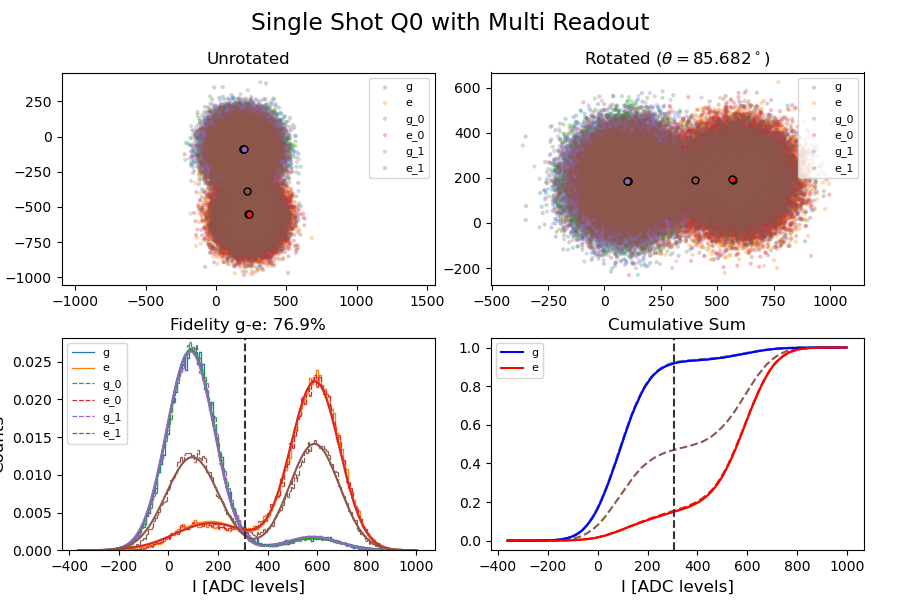

angle 85.68200511659992
11
[-230.4623443  -183.21321035 -135.96407641  -88.71494246  -41.46580851
    5.78332543   53.03245938  100.28159333  147.53072727  194.77986122
  242.02899516  289.27812911  341.56303565  397.20512392  452.84721218
  508.48930045  564.13138872  619.77347699  675.41556525  731.05765352]
optimal threshold 289.27812911126773
0.04111700978062126
n_e 0.03746302990469931
n_g 0.9625369700953007
n_e_prev 0.07850314012560503
n_g_prev 0.921496859874395
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 20, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


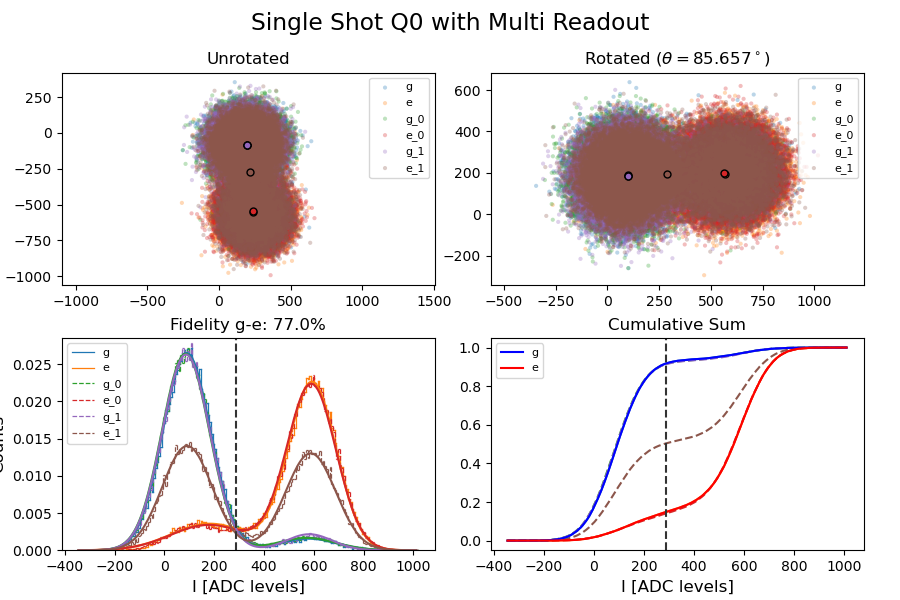

angle 85.65659520399996
11
[-202.41921384 -159.35448503 -116.28975621  -73.22502739  -30.16029857
   12.90443025   55.96915906   99.03388788  142.0986167   185.16334552
  228.22807434  271.29280316  324.46346538  384.37141655  444.27936771
  504.18731887  564.09527004  624.0032212   683.91117237  743.81912353]
optimal threshold 271.29280315511915
0.03977844234876662
n_e 0.048398544938337326
n_g 0.9516014550616627
n_e_prev 0.08802352094083764
n_g_prev 0.9119764790591623
{'reps': 50000, 'check_e': True, 'check_f': False, 'qTest': 0, 'readout_cool': True, 'n_init_readout': 1, 'n_trig': 1, 'init_read_wait_us': 40, 'use_gf_readout': False, 'avg_trigs': True}
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
wheres my plot


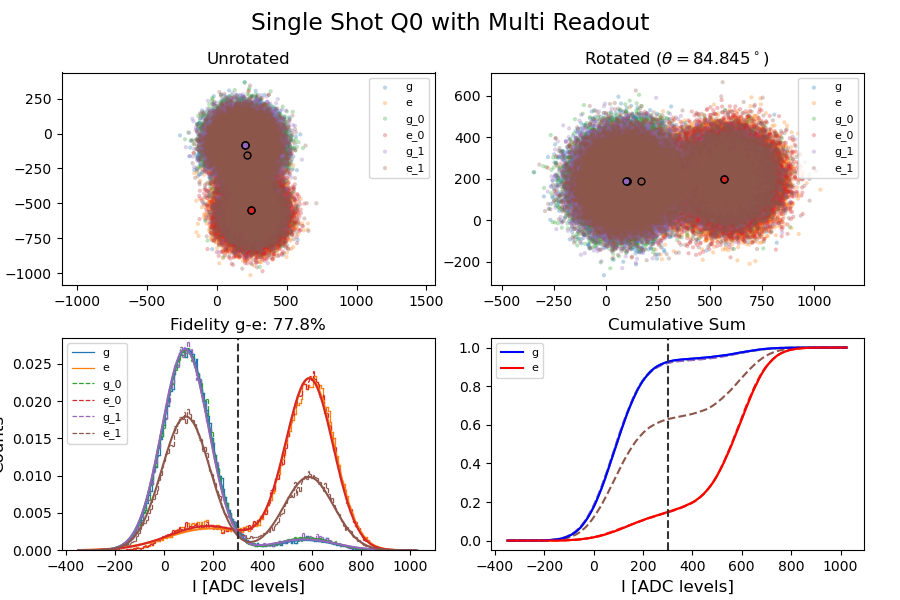

angle 84.84496600074849
11
[-232.81824073 -186.07878431 -139.33932789  -92.59987147  -45.86041504
    0.87904138   47.6184978    94.35795422  141.09741064  187.83686706
  234.57632348  281.3157799   334.51217501  392.01319591  449.51421681
  507.01523771  564.51625861  622.0172795   679.5183004   737.0193213 ]
optimal threshold 281.31577990395033
0.02838455962178253
n_e 0.05399667308702504
n_g 0.946003326912975
n_e_prev 0.08206
n_g_prev 0.91794


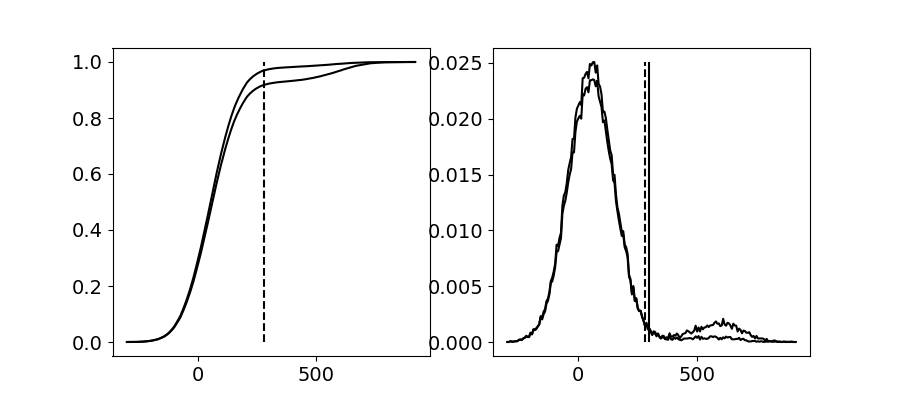

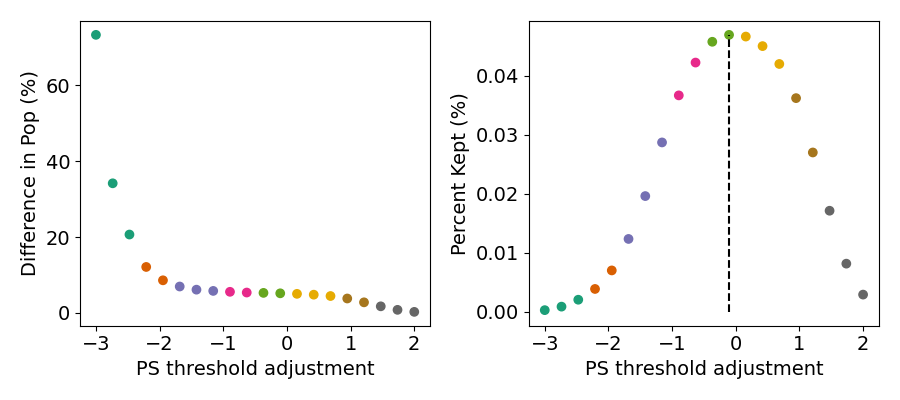

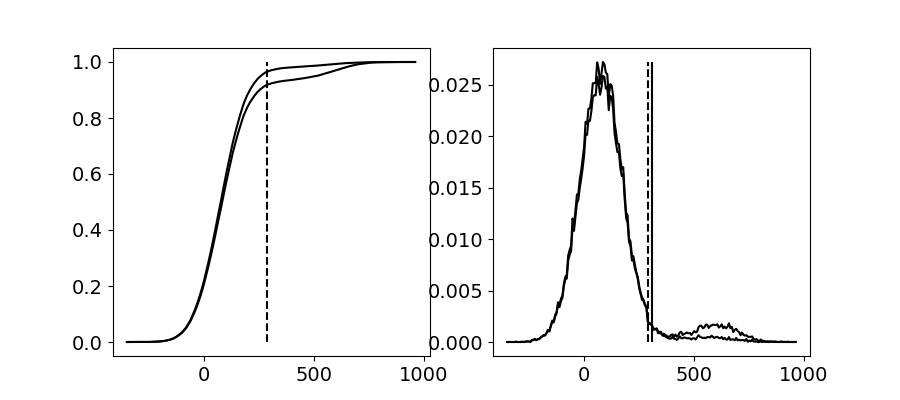

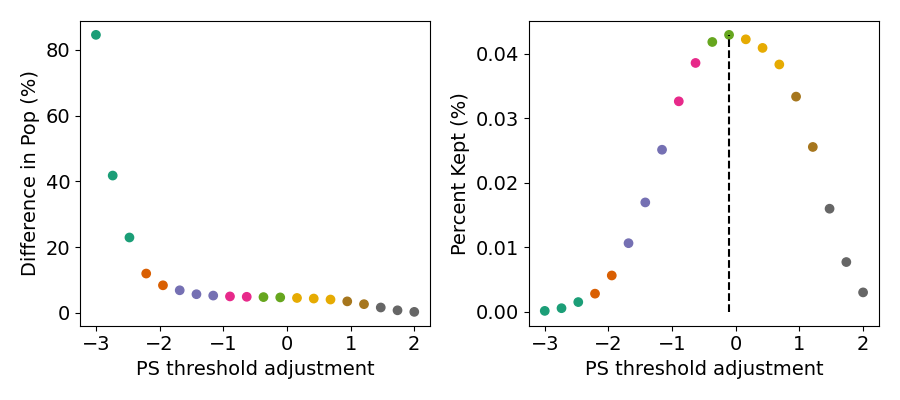

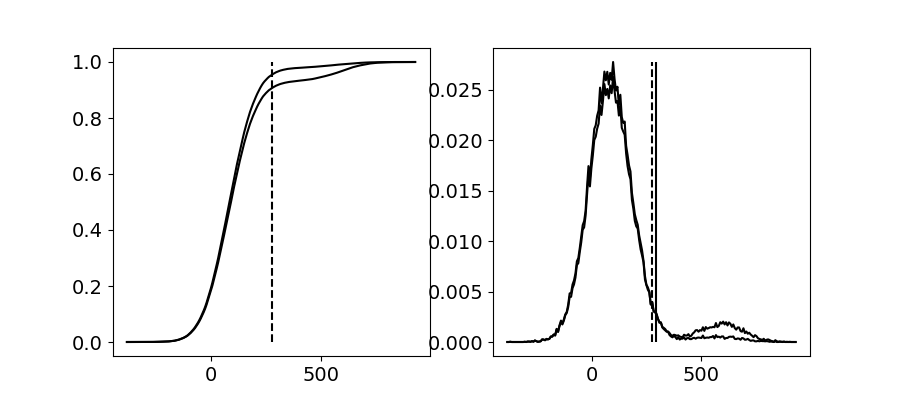

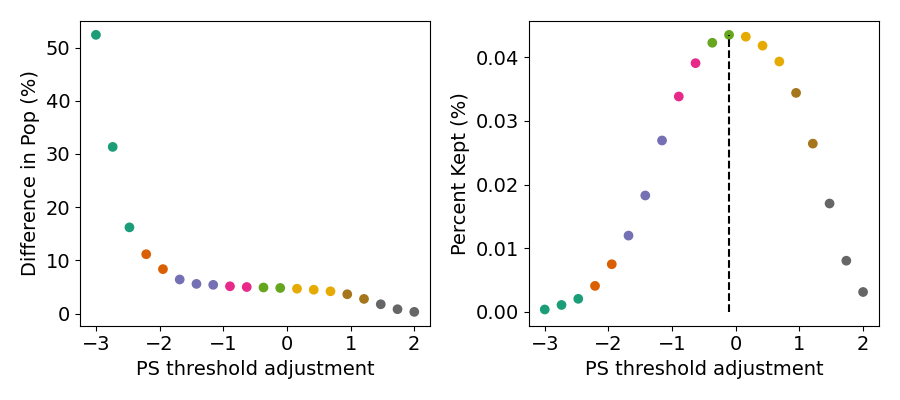

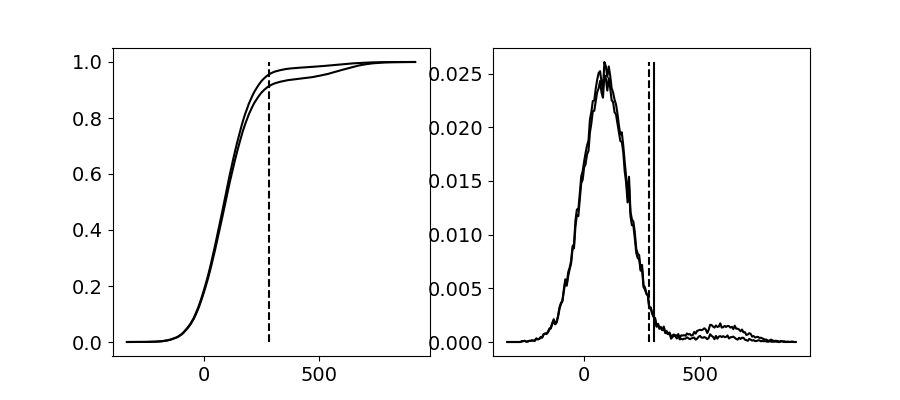

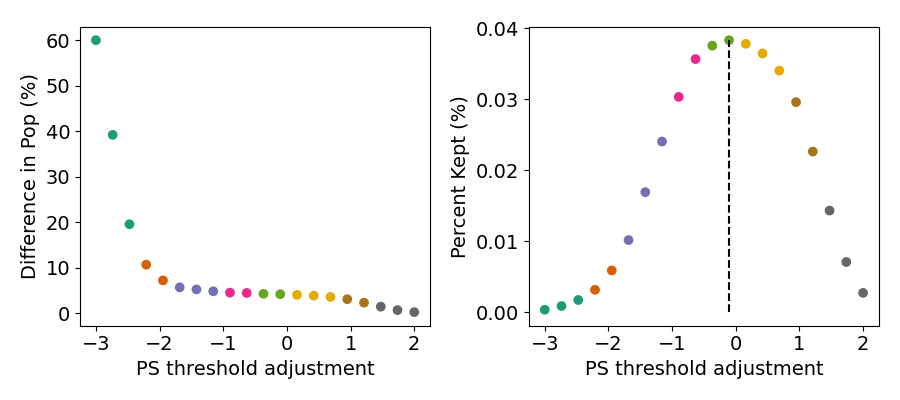

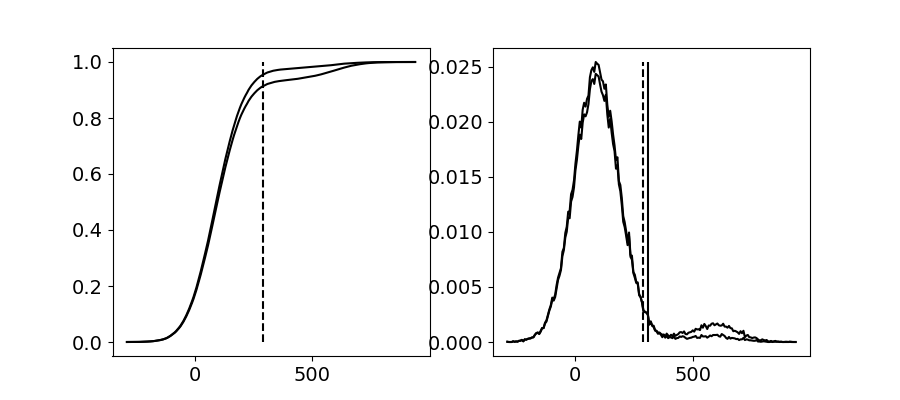

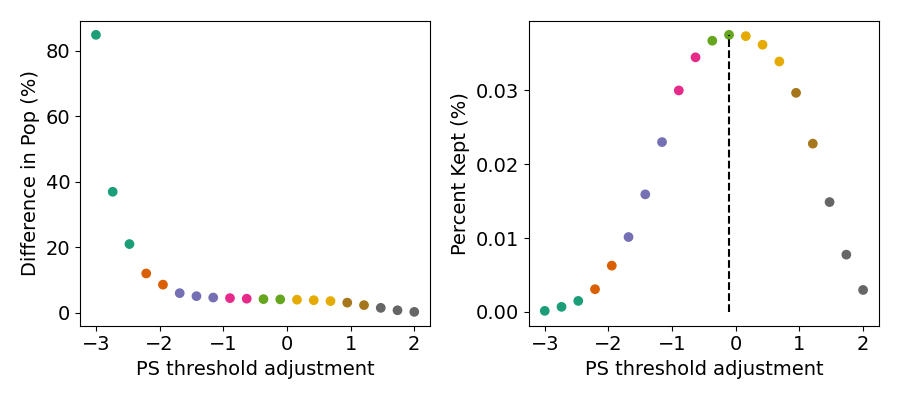

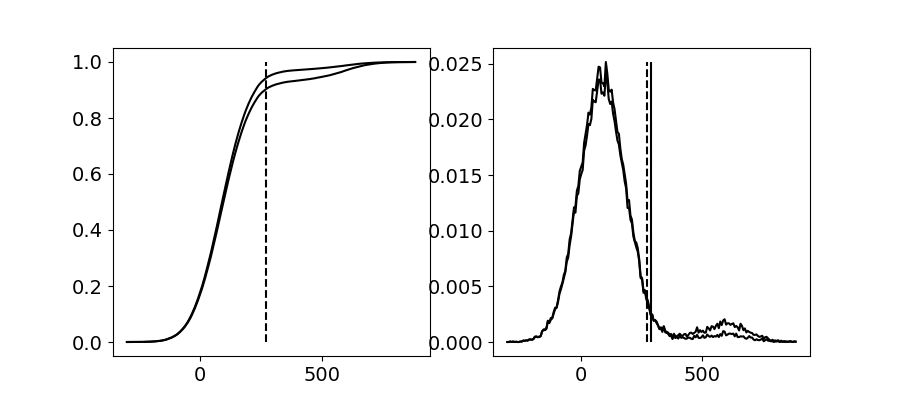

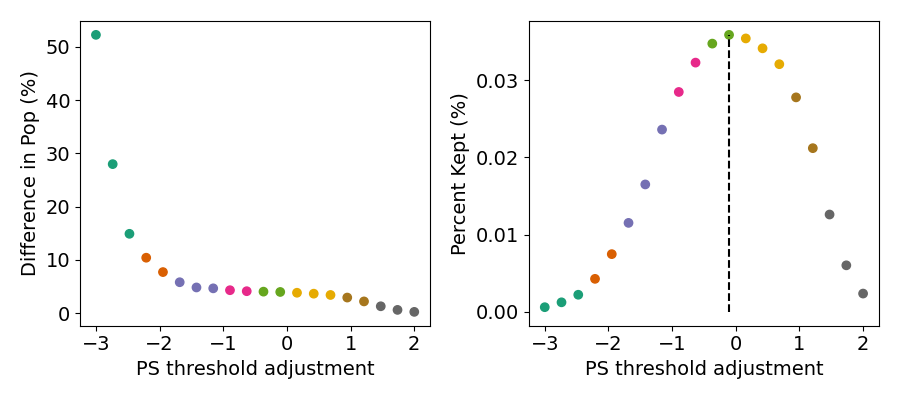

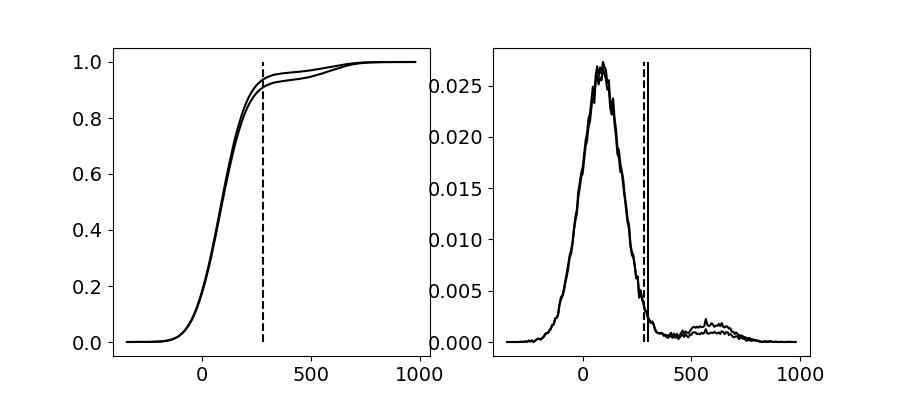

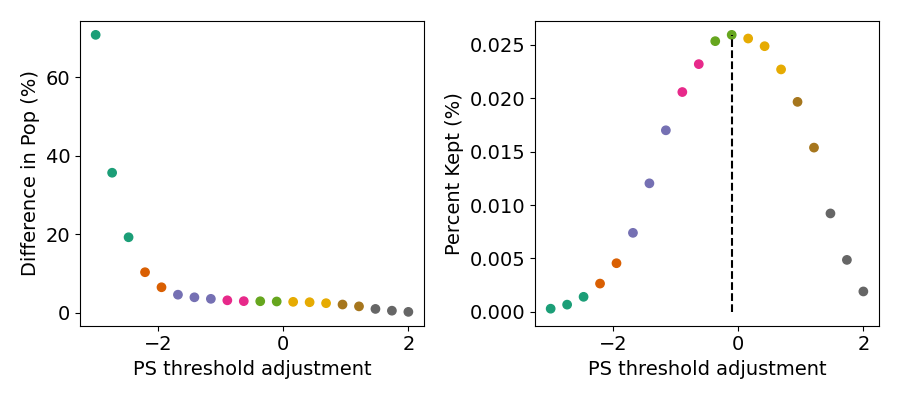

In [16]:

# # q0 
idx = np.arange(64, 71)
qubit=0
file_nb =  ['000'+str(i) for i in idx]
# # q1 
# idx = np.arange(89, 99)
# qubit=1
# file_nb =  ['000'+str(i) for i in idx]
# q2
# idx = np.arange(41, 50)
# qubit=2
# file_nb =  ['000'+str(i) for i in idx]
# q3
# idx = np.arange(105, 115)
# qubit=3
# file_nb =  ['00'+str(i) for i in idx]




filename = '_multi_readout_qubit'

wait_vec = []
pop_qnd_g = []
pop_diff = []

pop_vec = []
pop_vec_no_ps = []

data = []

for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)
    

for idx, d in enumerate(data):
    
    _data, _attrs = data[idx]
    shot = meas.MultiReadoutExperiment(config_file=config_path)
    
    config =  AttrDict(_attrs['config'])
    shot.cfg = config
    
    print(config.expt)
    
    
    _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 1], verbose=False, fit=True, plot=True, check_qnd=True, opti_post_select=True)
    
    wait_vec.append(config.expt.init_read_wait_us)
    pop_qnd_g.append(_d['n_diff_qnd'])
    pop_diff.append(_d['n_diff_opt'])
    
    pop_vec.append(_d['n_ps'][1])
    pop_vec_no_ps.append(_d['n_no_ps'][1])
         

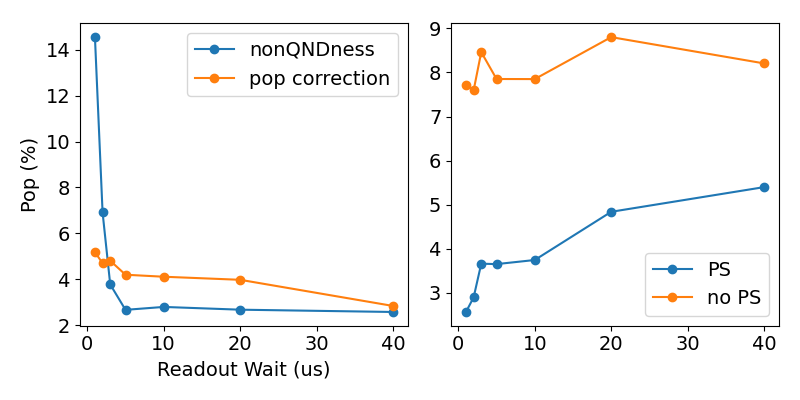

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(8,4))

ax1.plot(wait_vec, np.array(pop_qnd_g)*100,'-o', label='nonQNDness')
ax1.plot(wait_vec, np.array(pop_diff)*100,'-o', label='pop correction')


ax2.plot(wait_vec, np.array(pop_vec)*100,'-o', label='PS')
ax2.plot(wait_vec, np.array(pop_vec_no_ps)*100,'-o', label='no PS')

ax1.set_xlabel('Readout Wait (us)')
ax1.set_ylabel('Pop (%)')
fig.tight_layout()
ax1.legend()
ax2.legend()





# savefig

# fig.savefig('plots/qubit3_pop_vs_wait.png', bbox_inches='tight')



### Play with the number of trigger

s:\Connie\experiments\qramLL_4QR2\data\data_240617\00071_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00072_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00073_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00074_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00075_multi_readout_qubit0.h5
Extracted data and attrs ['config']
s:\Connie\experiments\qramLL_4QR2\data\data_240617\00076_multi_readout_qubit0.h5
Extracted data and attrs ['config']
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.026266350786264245
0.026266350786264245
wheres my plot


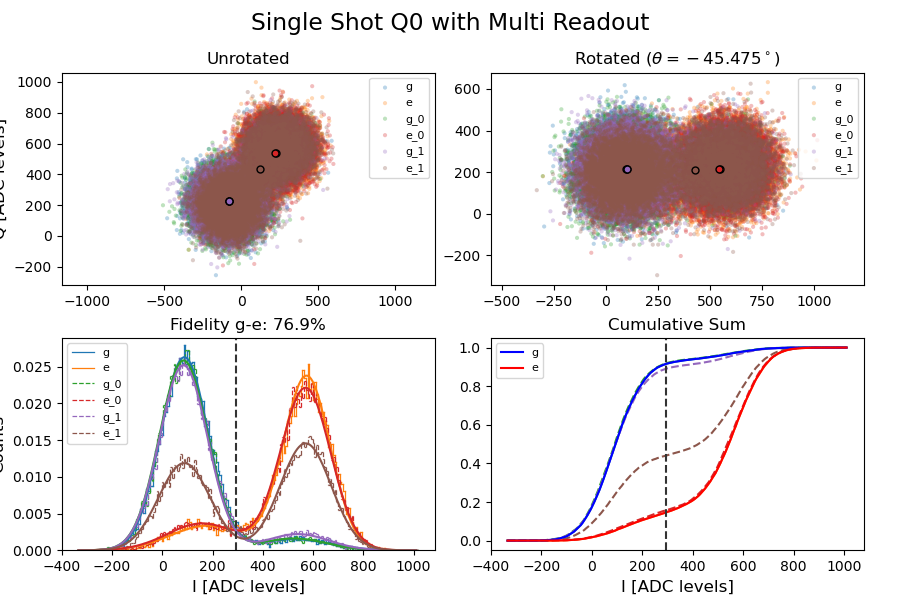

angle -45.47494225314599
5
[-96.24727273 -57.80264973 -19.35802673  19.08659627  57.53121927
  95.97584226 134.42046526 172.86508826 211.30971126 249.75433426
 288.19895726 334.22727006 381.73018921 429.23310837 476.73602752
 524.23894668 571.74186583 619.24478499 666.74770414 714.25062329]
optimal threshold 95.97584226460154
0.06707742794547136
n_e 0.051587301587301584
n_g 0.9484126984126984
n_e_prev 0.11160558027901395
n_g_prev 0.8883944197209861
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.026071217572178153
0.026071217572178153
0.03178577696016614
0.03178577696016614
wheres my plot


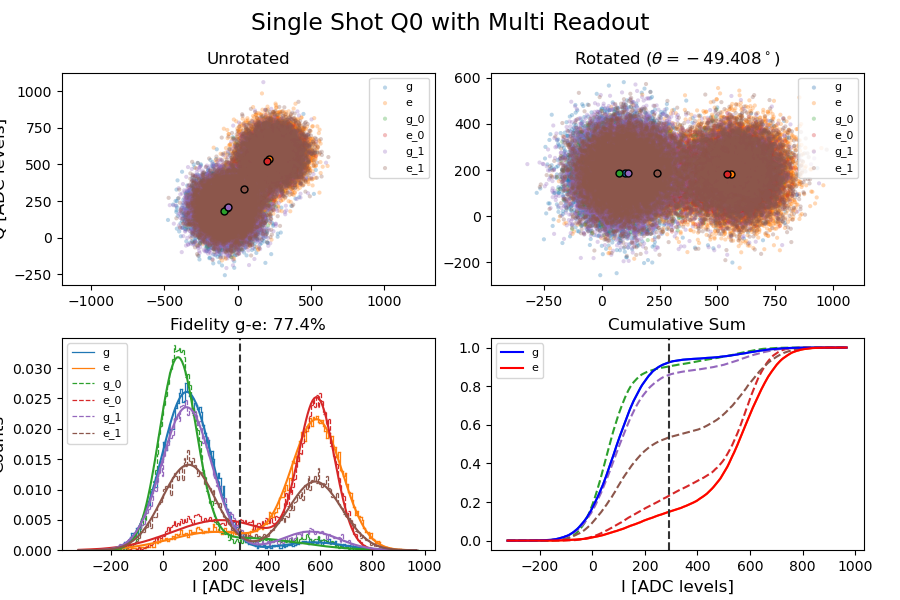

angle -49.40838312892335
4
[-97.81464516 -59.34485754 -20.87506991  17.59471771  56.06450533
  94.53429296 133.00408058 171.47386821 209.94365583 248.41344346
 286.88323108 334.63652965 384.19495534 433.75338104 483.31180673
 532.87023242 582.42865812 631.98708381 681.5455095  731.1039352 ]
optimal threshold 56.06450533494126
0.0968199463812959
n_e 0.051477713178294575
n_g 0.9485222868217055
n_e_prev 0.14196943122024555
n_g_prev 0.8580305687797545
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.025319008762255832
0.025319008762255832
0.03325571681864026
0.03325571681864026
wheres my plot


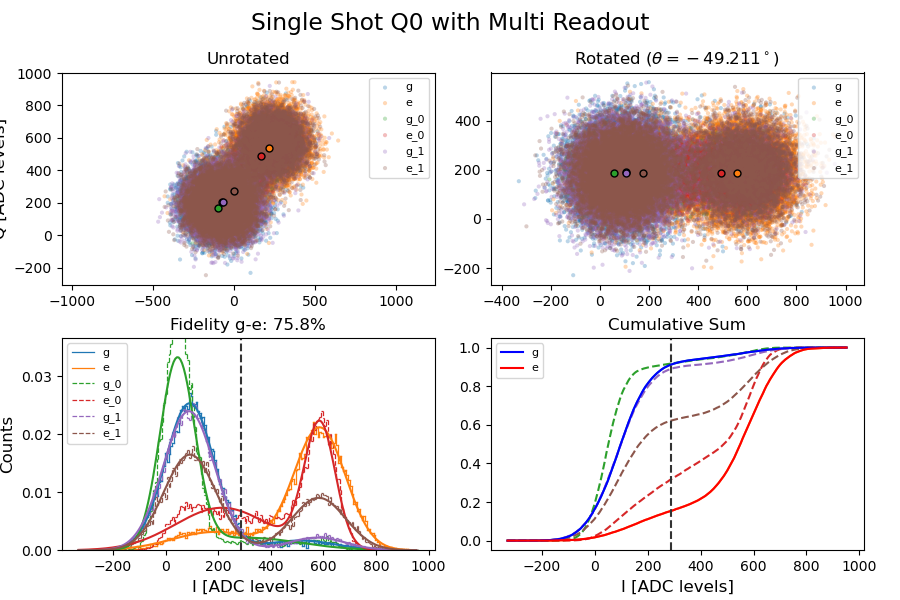

angle -49.210793714379626
3
[-84.65357948 -47.99350857 -11.33343767  25.32663324  61.98670415
  98.64677505 135.30684596 171.96691687 208.62698778 245.28705868
 281.94712959 329.56775997 379.31961025 429.07146053 478.82331081
 528.57516109 578.32701137 628.07886165 677.83071193 727.58256221]
optimal threshold 25.326633239527894
0.08324231940934285
n_e 0.040195089135553315
n_g 0.9598049108644466
n_e_prev 0.10884626970579375
n_g_prev 0.8911537302942062
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.024518544671074033
0.024518544671074033
0.037624551046539896
0.037624551046539896
wheres my plot


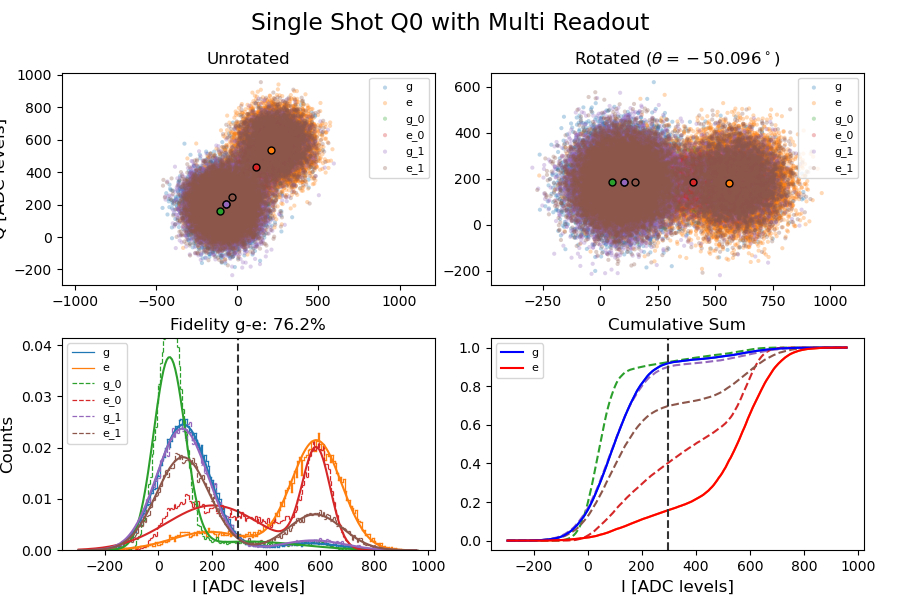

angle -50.09568593661749
3
[-90.45382111 -52.47084318 -14.48786525  23.49511269  61.47809062
  99.46106855 137.44404648 175.42702441 213.41000234 251.39298027
 289.3759582  336.09243822 384.50709919 432.92176016 481.33642114
 529.75108211 578.16574308 626.58040406 674.99506503 723.409726  ]
optimal threshold 23.49511268512566
0.07987830979863182
n_e 0.039567128846804196
n_g 0.9604328711531958
n_e_prev 0.09790316045380876
n_g_prev 0.9020968395461912
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.022994053728787097
0.022994053728787097
0.02721389420501146
0.02721389420501146
wheres my plot


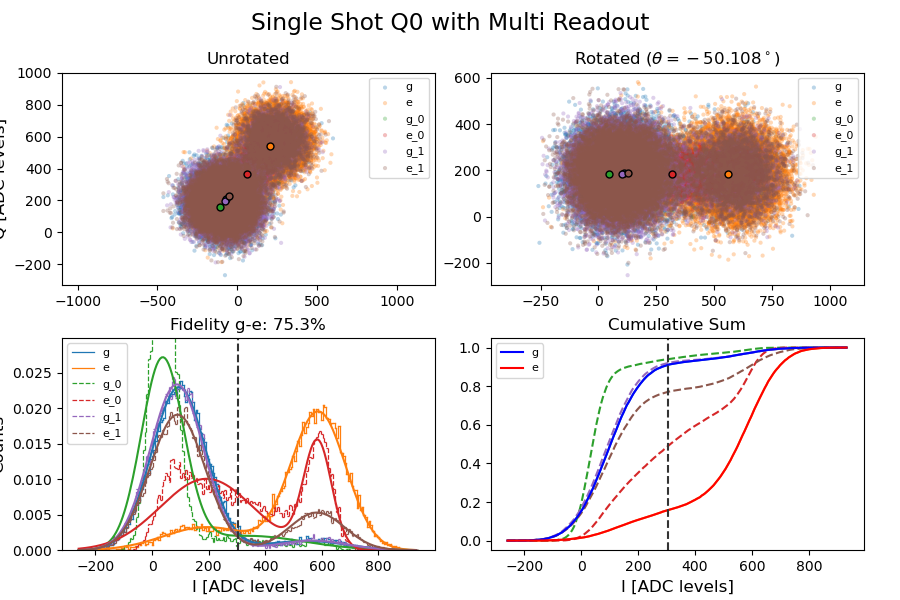

angle -50.10832718905028
2
[-87.02272239 -48.57602891 -10.12933542  28.31735806  66.76405155
 105.21074503 143.65743851 182.104132   220.55082548 258.99751897
 297.44421245 342.88113695 389.67727303 436.47340911 483.26954519
 530.06568127 576.86181735 623.65795343 670.45408952 717.2502256 ]
optimal threshold -10.129335423356679
0.09458992400408496
n_e 0.031206975676916018
n_g 0.968793024323084
n_e_prev 0.07666886979510905
n_g_prev 0.923331130204891
dict_keys(['Ie', 'Ie_baseline', 'Ig', 'Ig_baseline', 'Qe', 'Qe_baseline', 'Qg', 'Qg_baseline', 'iqshots', 'ge_avgs'])
0.025540926972067543
0.025540926972067543
0.030290766896036284
0.030290766896036284
wheres my plot


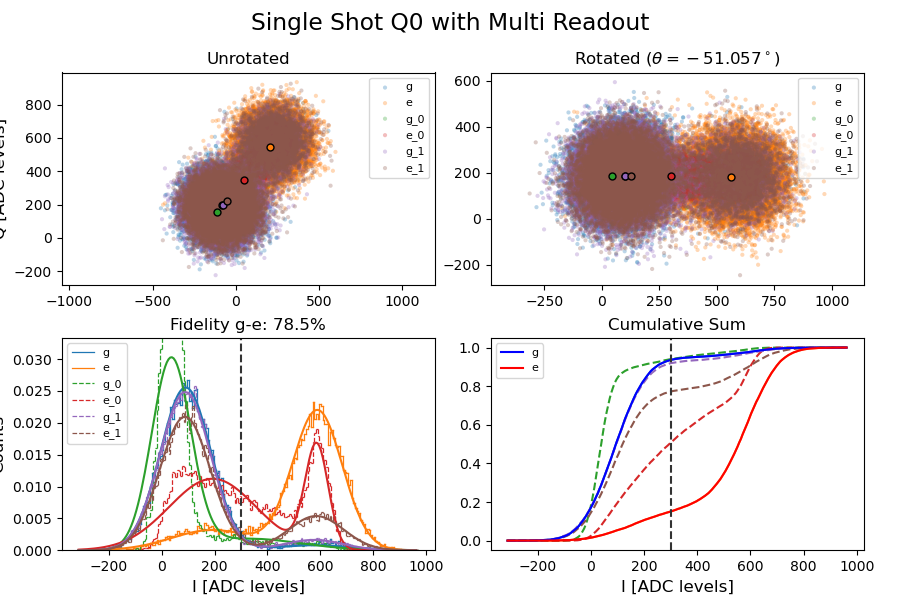

angle -51.05656485624435
-3
[-117.59612981  -76.35045299  -35.10477617    6.14090065   47.38657747
   88.63225429  129.8779311   171.12360792  212.36928474  253.61496156
  294.86063838  341.79765234  389.84131519  437.88497804  485.92864088
  533.97230373  582.01596658  630.05962943  678.10329228  726.14695513]
optimal threshold 630.0596294307179
0.002442125407281172
n_e 0.07399414213041468
n_g 0.9260058578695853
n_e_prev 0.07591824189334563
n_g_prev 0.9240817581066544


 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\single_shot.py: 1085RuntimeWarning: invalid value encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\single_shot.py: 1087

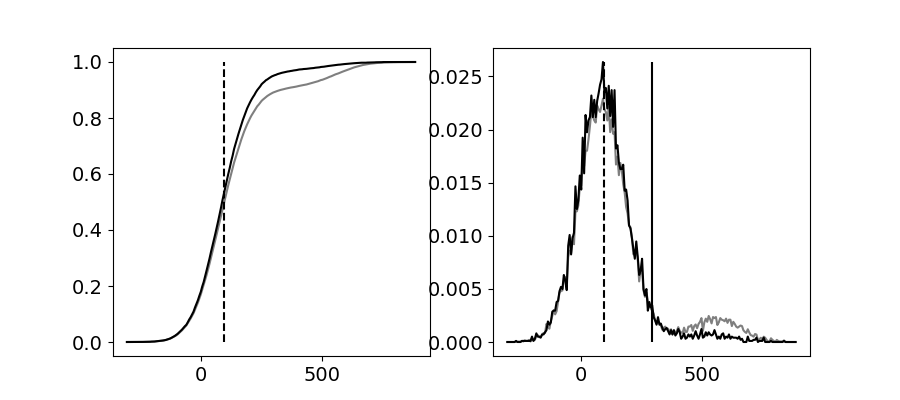

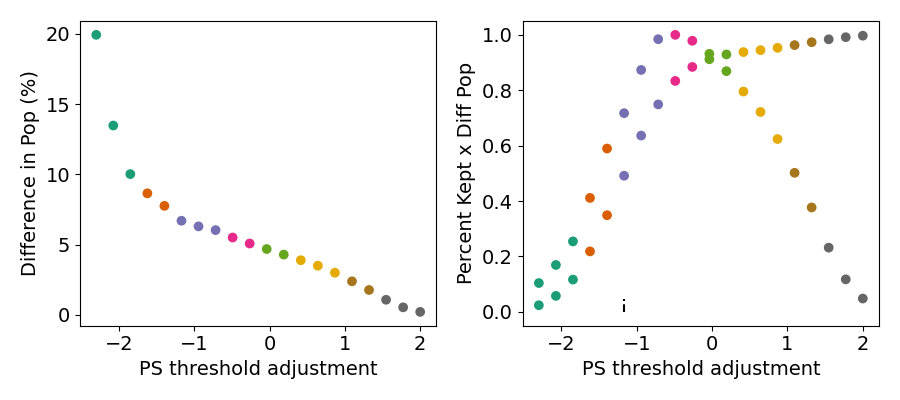

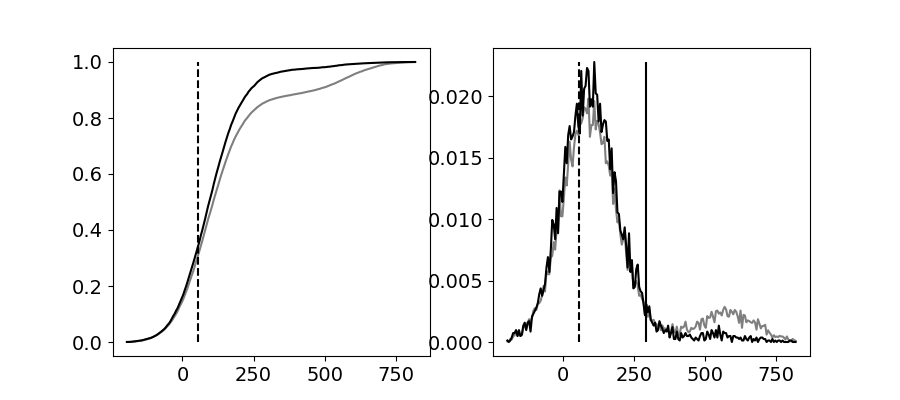

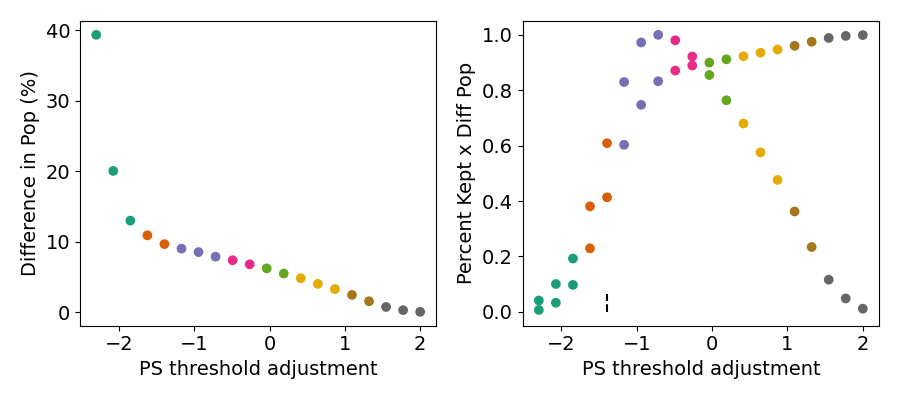

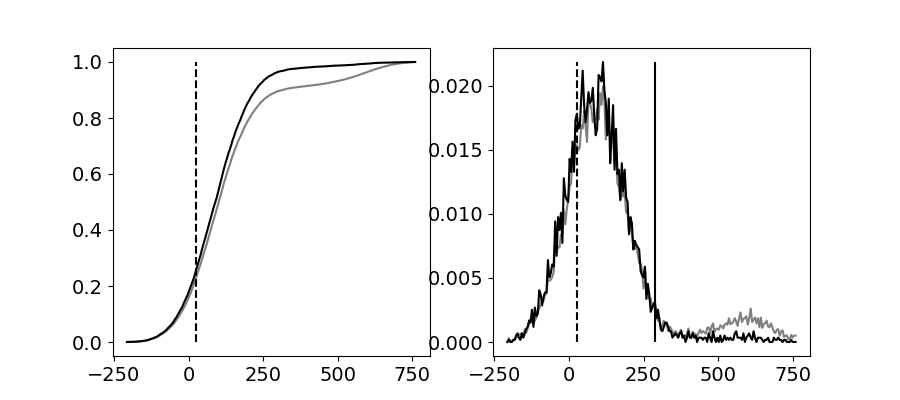

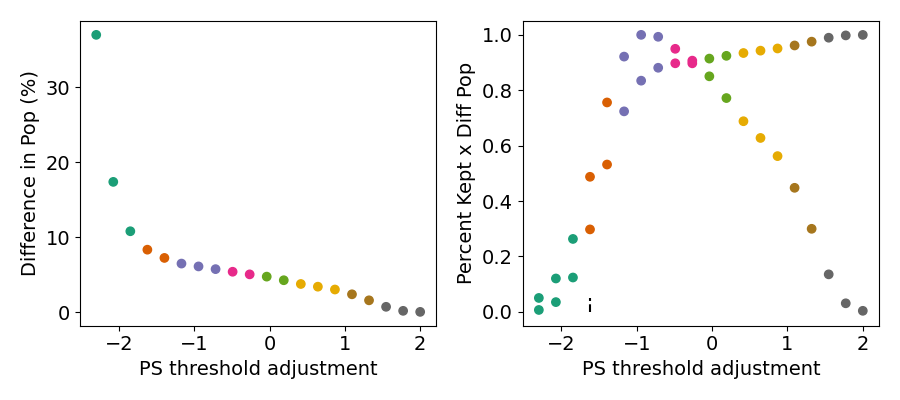

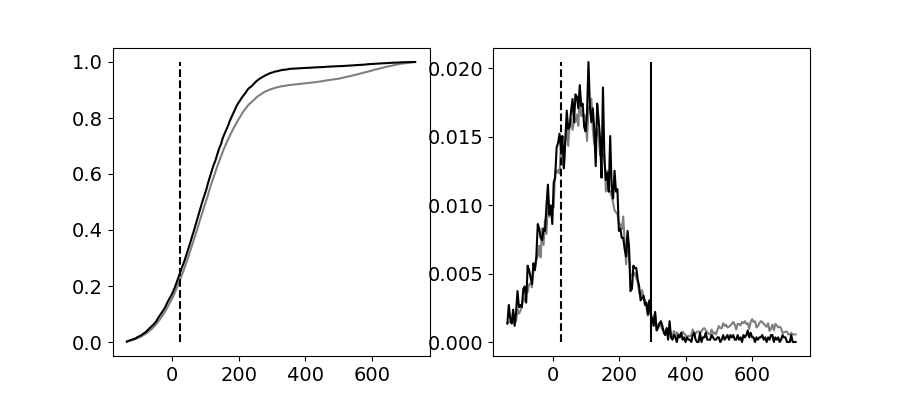

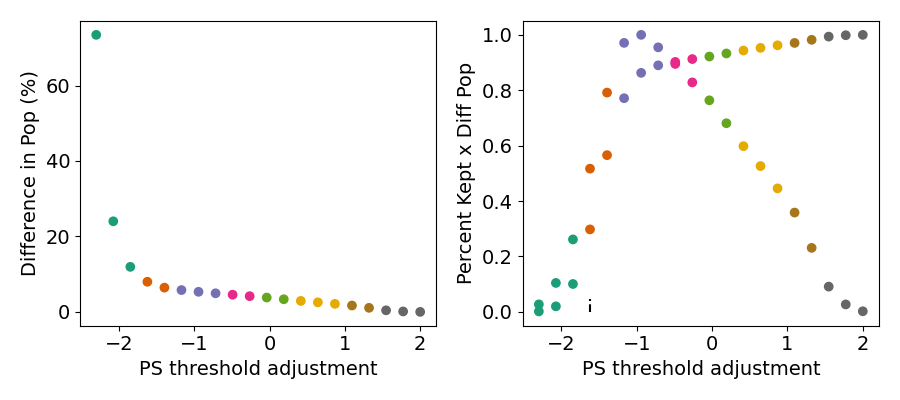

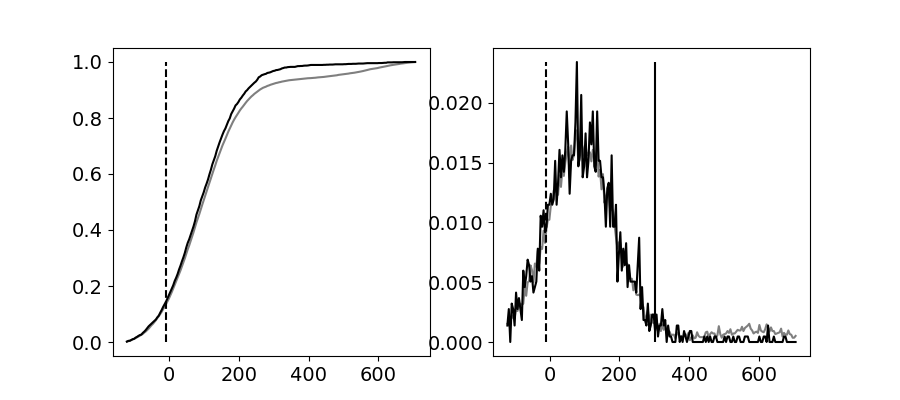

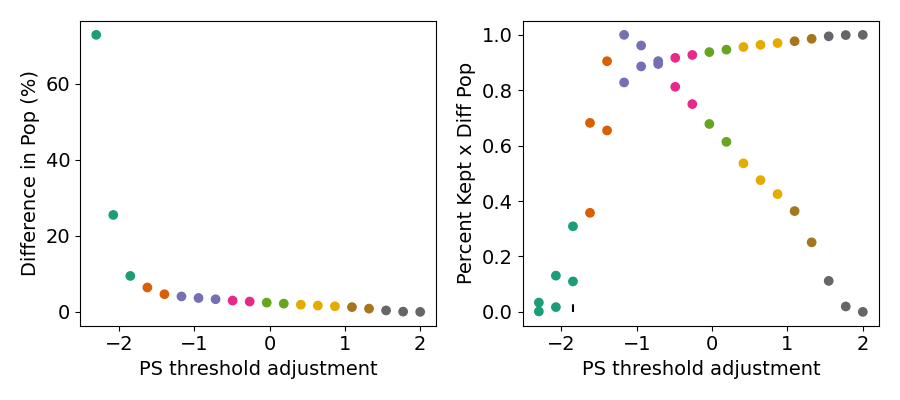

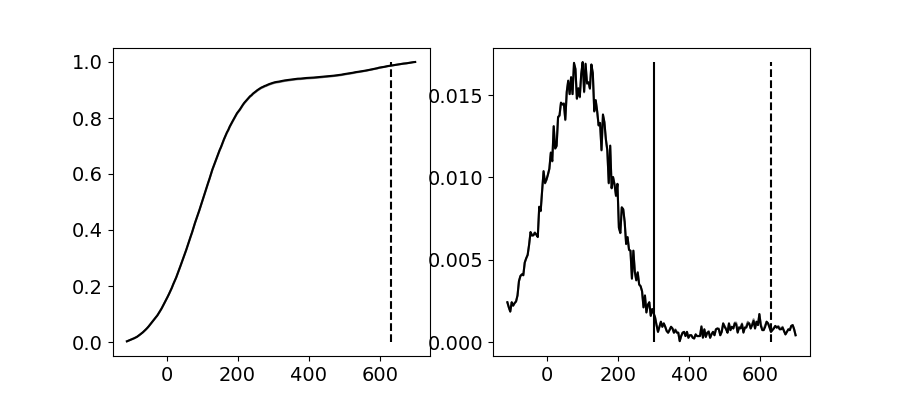

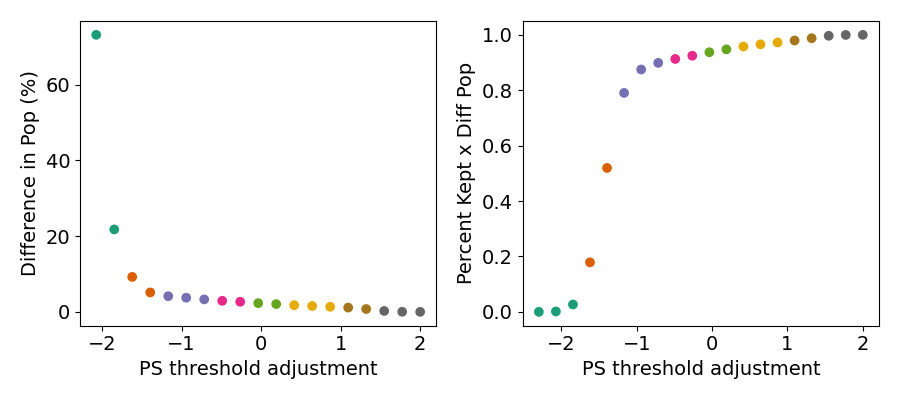

In [11]:
# idx = np.arange(99, 105)
# qubit = 1

idx= np.arange(71, 77)
qubit = 0


file_nb =  ['000'+str(i) for i in idx]
file_nb = [i[-5:] for i in file_nb]
filename = '_multi_readout_qubit'

data = []

for nb in file_nb:
    temp_data = prev_data(expt_path, f'{nb}{filename}{qubit}.h5')
    data.append(temp_data)
    
n_trigger = []
pop_qnd_g = []
pop_diff = []

for idx, d in enumerate(data):
        
        _data, _attrs = data[idx]
        shot = meas.MultiReadoutExperiment(config_file=config_path)
        
        config =  AttrDict(_attrs['config'])
        shot.cfg = config
        
        n_trigger.append(config.expt.n_trig)
        
        _d = shot.analyze(data=_data, check_readouts=[0,1], post_select=True, ps_adjust=[0, 0, 0, 1], verbose=False, fit=True, plot=True, check_qnd=True, opti_post_select=True)
        
        pop_qnd_g.append(_d['n_diff_qnd'])
        pop_diff.append(_d['n_diff_opt'])

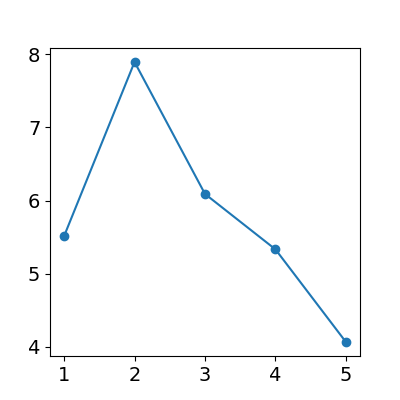

In [10]:
fig, ax = plt.subplots(1, 1,  figsize=(4,4))

# ax.plot(n_trigger, np.array(pop_qnd_g)*100,'-o', label='nonQNDness')
ax.plot(n_trigger, np.array(pop_diff)*100,'-o', label='pop correction')

